[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/DDPM.ipynb)

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.utils import make_grid

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
# transforms = torchvision.transforms.Compose([
#       torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
#       torchvision.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
#       torchvision.transforms.ToTensor(),
#       torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#   ])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=4) # loading the downloaded dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 133676651.90it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103094207.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70111732.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5229351.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Modelling

## Autoencoder (Unet)

In [5]:
'''
Input :
  time_steps : takes in 1D array of timesteps eg [1,10,500,40,300]
  temb_dim : dimension of vector to which each of these timestep needs to be converted to eg 128

Output :
  t_emd : for each scalar timestep in time_steps 1D array, convert it to a vector of dimension temb_dim
'''
def get_time_embedding(time_steps, temb_dim):

    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2)))

    # pos / factor
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor

    # now taking sin and cos of t_emb
    return torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)

In [6]:
class DownBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample, num_heads=4):
        super().__init__()

        self.resnet_conv_first = nn.Sequential( nn.GroupNorm(8, in_channels), nn.SiLU(), nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)) # Resnet block
        self.t_emb_layers = nn.Sequential( nn.SiLU(), nn.Linear(t_emb_dim, out_channels) ) # time embedding
        self.resnet_conv_second = nn.Sequential( nn.GroupNorm(8, out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels,kernel_size=3, stride=1, padding=1) ) # resnet block 2

        # Attention block
        # self.attention_norms = layer_1 = nn.GroupNorm(8, out_channels)
        # self.attentions = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        # Downsample using 2x2 average pooling
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1) if down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x

        # Resnet block of Unet
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        # Attention block of Unet
        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h * w)
        # in_attn = self.attention_norms(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attentions(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn

        out = self.down_sample_conv(out)
        return out

In [7]:
class MidBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4):
        super().__init__()

        # Resnet Block 1
        layer_1 = nn.Sequential(nn.GroupNorm(8, in_channels), nn.SiLU(), nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1))
        layer_2 = nn.Sequential(nn.GroupNorm(8, out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,padding=1))
        self.resnet_conv_first = nn.ModuleList( [layer_1, layer_2] )

        # time embedding
        layer = nn.Sequential(nn.SiLU(),nn.Linear(t_emb_dim, out_channels))
        self.t_emb_layers = nn.ModuleList([ layer, layer])

        # Resnet Block 2
        layer = nn.Sequential(nn.GroupNorm(8, out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
        self.resnet_conv_second = nn.ModuleList([ layer, layer])

        # Attention block
        # self.attention_norms = nn.GroupNorm(8, out_channels)
        # self.attentions = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

        # Resnet block
        layer_1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        layer_2 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.residual_input_conv = nn.ModuleList([layer_1, layer_2])

    def forward(self, x, t_emb):
        out = x

        # resnet block 1
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        # Attention Block
        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h * w)
        # in_attn = self.attention_norms(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attentions(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn

        # Resnet Block 2
        resnet_input = out
        out = self.resnet_conv_first[1](out)
        out = out + self.t_emb_layers[1](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[1](out)
        out = out + self.residual_input_conv[1](resnet_input)

        return out

In [8]:
class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads=4, num_layers=1):
        super().__init__()

        # Upsample
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,kernel_size=4, stride=2, padding=1) if up_sample else nn.Identity()

        # Resnet block
        self.resnet_conv_first = nn.Sequential( nn.GroupNorm(8, in_channels), nn.SiLU(), nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1) )
        # time embedding
        self.t_emb_layers = nn.Sequential( nn.SiLU(), nn.Linear(t_emb_dim, out_channels))
        # resnet block 2
        self.resnet_conv_second = nn.Sequential(nn.GroupNorm(8, out_channels), nn.SiLU(), nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))

        # Attention Block
        # self.attention_norms = nn.GroupNorm(8, out_channels)
        # self.attentions = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

        # Concatenate Down block output
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)



    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)

        out = x

        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        # batch_size, channels, h, w = out.shape
        # in_attn = out.reshape(batch_size, channels, h * w)
        # in_attn = self.attention_norms(in_attn)
        # in_attn = in_attn.transpose(1, 2)
        # out_attn, _ = self.attentions(in_attn, in_attn, in_attn)
        # out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        # out = out + out_attn

        return out

In [9]:
class Unet(nn.Module):

    def __init__(self):
        super().__init__()
        im_channels = 1
        self.t_emb_dim = 128

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential( nn.Linear(self.t_emb_dim, self.t_emb_dim), nn.SiLU(), nn.Linear(self.t_emb_dim, self.t_emb_dim))

        # 1 layer of conv2d, you can add more conv2d layers if you want to and between these conv layer add group norm followed by activation function like GELU()
        self.conv_in = nn.Conv2d(im_channels, 32, kernel_size=3, padding=(1, 1))

        # down block
        down_layer_1 = DownBlock(32, 128, self.t_emb_dim, True)
        # down_layer_2 = DownBlock(64, 128, self.t_emb_dim, True)
        down_layer_2 = DownBlock(128, 256, self.t_emb_dim, False)
        self.downs = nn.ModuleList([down_layer_1, down_layer_2])

        # mid block
        mid_layer_1 = MidBlock(256, 256, self.t_emb_dim)
        mid_layer_2 = MidBlock(256, 128, self.t_emb_dim)
        self.mids = nn.ModuleList([mid_layer_1, mid_layer_2])

        # up block
        up_layer_1 = UpBlock(128 * 2, 32, self.t_emb_dim, False)
        # up_layer_2 = UpBlock(64 * 2, 32, self.t_emb_dim, True)
        up_layer_2 = UpBlock(32 * 2, 16, self.t_emb_dim, True)
        self.ups = nn.ModuleList([up_layer_1, up_layer_2])

        # groupNorm
        self.norm_out = nn.GroupNorm(8, 16)

        # conv2d
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W

        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)


        # keep saving outputs of down block cause we need it as input for upblock
        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

## Training

In [10]:
batch_size = 64
num_samples = 100
num_grid_rows = 10

model = Unet().to(device)
model.train()
optimizer = Adam(model.parameters(), lr = 0.0001)

betas = torch.linspace(0.0001, 0.02, 1000).to(device) # creating a linear beta schedule for all the timestamps
alpha_cum_prod = torch.cumprod(1. - betas, dim=0).to(device) # calculating alpha_bar for each timestamp
sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod).to(device) # calculating sqrt(alpha_bar) for each timestamp
sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod).to(device) # calculating sqrt(1-alpha_bar) for each timestamp

In [11]:
for epoch in range(40): # running for 40 epochs
  losses = []
  for im,_ in tqdm(mnist_loader):
    optimizer.zero_grad()

    im = im.float().to(device)
    noise = torch.randn_like(im).to(device) # sample random noise
    t = torch.randint(low = 0, high = 1000, size = (im.shape[0],)).to(device) # sample a random timestamp for each image in the batch
    noisy_im = torch.sqrt(alpha_cum_prod[t])[:, None, None, None].to(device) * im + torch.sqrt(1 - alpha_cum_prod[t])[:, None, None, None].to(device) * noise # add noise to image according to the timestamp
    noise_pred = model(noisy_im, t) # predicting the added noise

    loss = torch.nn.MSELoss()(noise_pred, noise) # loss fucntion
    losses.append(loss.item())
    loss.backward() # backpropagating the loss
    optimizer.step()
  print()

100%|██████████| 938/938 [01:19<00:00, 11.79it/s]


100%|██████████| 938/938 [01:21<00:00, 11.46it/s]


100%|██████████| 938/938 [01:21<00:00, 11.51it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.46it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.45it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.52it/s]


100%|██████████| 938/938 [01:21<00:00, 11.50it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.45it/s]


100%|██████████| 938/938 [01:21<00:00, 11.45it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.50it/s]


100%|██████████| 938/938 [01:21<00:00, 11.46it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.45it/s]


100%|██████████| 938/938 [01:21<00:00, 11.50it/s]


100%|██████████| 938/938 [01:21<00:00, 11.50it/s]


100%|██████████| 938/938 [01:21<00:00, 11.47it/s]


100%|██████████| 938/938 [01:21<00:00, 11.50it/s]


100%|██████████| 938/938 [01:21<00:00, 11.48it/s]


100%|██████████| 938/938 [01:21<00:00, 11.51it/s]

# Inference

In [12]:
model.eval()
batch_size = 64
num_epochs = 40
num_samples = 100
num_grid_rows = 10
im_channels = 1
im_size = 28

In [13]:
with torch.no_grad():
    # creating a random noise sample based on number of images requested to generate
    xt = torch.randn((num_samples, im_channels, im_size, im_size)).to(device)
    for i in tqdm(reversed(range(1000))):

        t = torch.as_tensor(i)
        noise_pred = model(xt, t.unsqueeze(0).to(device)) # Get prediction of noise

        # timestep
        t = t.to(device)

        # calculating Xt-1 using the derived formula
        mean = (xt - ((betas[t])*noise_pred)/(sqrt_one_minus_alpha_cum_prod[t])) / torch.sqrt(1. - betas[t])
        variance = ( (1-alpha_cum_prod[t-1]) / (1.0 - alpha_cum_prod[t]) ) * betas[t]
        sigma = variance ** 0.5 if t != 0 else 0
        xt = mean + sigma * torch.randn(xt.shape).to(xt.device)

        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = 0.5*ims + 0.5
        grid = make_grid(ims, nrow= num_grid_rows)

        # predicted image
        img = torchvision.transforms.ToPILImage()(grid)

1000it [00:52, 19.21it/s]


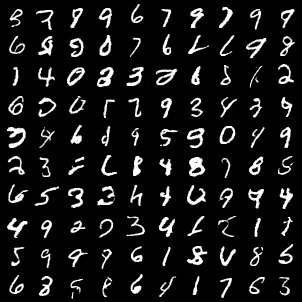

In [14]:
img